# Implementing a one-layer Neural Network


We will illustrate how to create a one hidden layer NN

We will use the iris data for this exercise

We will build a one-hidden layer neural network  to predict the fourth attribute, Petal Width from the other three (Sepal length, Sepal width, Petal length).

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import datasets


Bad key "text.kerning_factor" on line 4 in
/Users/alexia/anaconda2/envs/tf2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


## Load iris dataset

In [ ]:
iris = datasets.load_iris()
# Get Sepal length, Sepal width, Petal length
x_vals = np.array([x[0:3] for x in iris.data])
# Get Petal Width
y_vals = np.array([x[3] for x in iris.data])

In [ ]:
# make results reproducible
seed = 3
np.random.seed(seed)  
tf.random.set_seed(seed)

In [ ]:
# Split data into train/test = 80%/20%
train_indices = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

In [ ]:
# Normalize by column (min-max norm)
def normalize_cols(m):
    col_max = m.max(axis=0)
    col_min = m.min(axis=0)
    return (m-col_min) / (col_max - col_min)
    
x_vals_train = np.nan_to_num(normalize_cols(x_vals_train))
x_vals_test = np.nan_to_num(normalize_cols(x_vals_test))

In [ ]:
# Declare batch size
batch_size = 50

# Initialize input data
x_data = tf.keras.Input(dtype=tf.float32, shape=(3,))

In [ ]:
# Create variables for both NN layers
hidden_layer_nodes = 5
a1 = tf.Variable(tf.random.normal(shape=[3,hidden_layer_nodes], seed=seed)) # inputs -> hidden nodes
b1 = tf.Variable(tf.random.normal(shape=[hidden_layer_nodes], seed=seed))   # one biases for each hidden node
a2 = tf.Variable(tf.random.normal(shape=[hidden_layer_nodes,1], seed=seed)) # hidden inputs -> 1 output
b2 = tf.Variable(tf.random.normal(shape=[1], seed=seed))   # 1 bias for the output


# Declare model operations
hidden_output = tf.keras.layers.Lambda(lambda x: tf.nn.relu(tf.add(tf.matmul(x, a1), b1)))
final_output = tf.keras.layers.Lambda(lambda x: tf.nn.relu(tf.add(tf.matmul(x, a2), b2)))

hidden_layer = hidden_output(x_data)
output = final_output(hidden_layer)

# Build the model
model = tf.keras.Model(inputs=x_data, outputs=output, name="1layer_neural_network")

# Declare optimizer
optimizer = tf.keras.optimizers.SGD(0.005)

The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(3, 5) dtype=float32>
  <tf.Variable 'Variable:0' shape=(5,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (lambda_1), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(5, 1) dtype=float32>
  <tf.Variable 'Variable:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


In [ ]:
# Training loop
loss_vec = []
test_loss = []
for i in range(500):
    rand_index = np.random.choice(len(x_vals_train), size=batch_size)
    rand_x = x_vals_train[rand_index]
    rand_y = np.transpose([y_vals_train[rand_index]])
    
    # Open a GradientTape.
    with tf.GradientTape(persistent=True) as tape:
   
        # Forward pass.
        output = model(rand_x)
        
        # Apply loss function (MSE)
        loss = tf.reduce_mean(tf.square(rand_y - output))
        loss_vec.append(np.sqrt(loss))       
        
    # Get gradients of loss with reference to the variables "a1", "b1", "a2" and "b2" to adjust.
    gradients_a1 = tape.gradient(loss, a1)
    gradients_b1 = tape.gradient(loss, b1)
    gradients_a2 = tape.gradient(loss, a2)
    gradients_b2 = tape.gradient(loss, b2)
    
    # Update the variables "a1", "b1", "a2" and "b2" of the model.
    optimizer.apply_gradients(zip([gradients_a1, gradients_b1, gradients_a2, gradients_b2], [a1, b1, a2, b2]))
    
    # Forward pass.
    output_test = model(x_vals_test)
    # Apply loss function (MSE) on test
    loss_test = tf.reduce_mean(tf.square(np.transpose([y_vals_test]) - output_test))
    test_loss.append(np.sqrt(loss_test))
    
    if (i+1)%50==0:
        print('Generation: ' + str(i+1) + '. Loss = ' + str(np.mean(loss)))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Generation: 50. Loss = 0.6273957
Generation: 100. Loss = 0.15347697
Generation: 150. Loss = 0.15431024
Generation: 200. Loss = 0.11715934
Generation: 250. Loss = 0.12236561
Generation: 300. Loss = 0.12134756
Generation: 350. Loss = 0.072587565
Generation: 400. Loss = 0.14590776
Generation: 450. Loss = 0.14075774
Generation: 500. Loss = 0.13127385


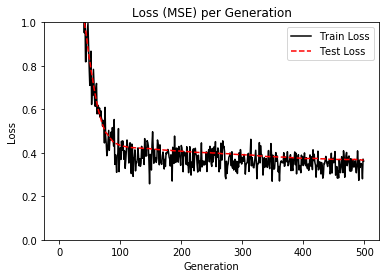

In [ ]:
%matplotlib inline
# Plot loss (MSE) over time
plt.ylim([0, 1.0])
plt.plot(loss_vec, 'k-', label='Train Loss')
plt.plot(test_loss, 'r--', label='Test Loss')
plt.title('Loss (MSE) per Generation')
plt.legend(loc='upper right')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()